# Resnet 18 from Scratch

> Resnet 18 from Scratch


- skip_showdoc: true
- skip_exec: true

In [ ]:
#| default_exp resnet18

In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *
from nbdevAuto import functions
import os
import shutil

In [ ]:
import torch.nn as nn
import torch
from torch import Tensor
from typing import Type

In [ ]:
class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out

In [ ]:
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature 
        # map should be (7, 7) for all ResNets.
        #print('Dimensions of the last convolutional feature map: ', x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
tensor = torch.rand([1, 3, 224, 224])
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=1000)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
output = model(tensor)

11,689,512 total parameters.
11,689,512 training parameters.


In [ ]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
plt.style.use('ggplot')
def get_data(batch_size=64):
    # CIFAR10 training dataset.
    dataset_train = datasets.CIFAR10(
        root='data',
        train=True,
        download=True,
        transform=ToTensor(),
    )
    # CIFAR10 validation dataset.
    dataset_valid = datasets.CIFAR10(
        root='data',
        train=False,
        download=True,
        transform=ToTensor(),
    )
    # Create data loaders.
    train_loader = DataLoader(
        dataset_train, 
        batch_size=batch_size,
        shuffle=True
    )
    valid_loader = DataLoader(
        dataset_valid, 
        batch_size=batch_size,
        shuffle=False
    )
    return train_loader, valid_loader

In [ ]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, name=None):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
import torch
from tqdm import tqdm
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# Validation function.
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import numpy as np
import random

# Set seed.
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

In [ ]:
# Learning and training parameters.
epochs = 20
batch_size = 64
learning_rate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_loader, valid_loader = get_data(batch_size=batch_size)
# Define model based on the argument parser string.

print('[INFO]: Training ResNet18 built from scratch...')
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=10).to(device)
plot_name = 'resnet_scratch'

# print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Loss function.
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
[INFO]: Training ResNet18 built from scratch...
11,181,642 total parameters.
11,181,642 training parameters.


[INFO]: Epoch 1 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 44.98it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 83.11it/s]


Training loss: 1.421, training acc: 48.966
Validation loss: 1.590, validation acc: 45.520
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.09it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.99it/s]


Training loss: 1.021, training acc: 63.716
Validation loss: 1.145, validation acc: 60.090
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 54.44it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 78.70it/s]


Training loss: 0.834, training acc: 70.488
Validation loss: 1.317, validation acc: 57.260
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 44.86it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 73.68it/s]


Training loss: 0.701, training acc: 75.158
Validation loss: 2.220, validation acc: 46.050
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 44.30it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 73.34it/s]


Training loss: 0.595, training acc: 78.946
Validation loss: 2.410, validation acc: 41.760
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.72it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 73.03it/s]


Training loss: 0.495, training acc: 82.466
Validation loss: 1.990, validation acc: 47.290
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:18<00:00, 42.86it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 77.01it/s]


Training loss: 0.410, training acc: 85.436
Validation loss: 2.319, validation acc: 45.660
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.12it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 76.58it/s]


Training loss: 0.341, training acc: 87.844
Validation loss: 1.169, validation acc: 66.930
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 52.23it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 78.26it/s]


Training loss: 0.272, training acc: 90.396
Validation loss: 2.214, validation acc: 50.400
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 53.12it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 76.25it/s]


Training loss: 0.223, training acc: 92.148
Validation loss: 1.630, validation acc: 61.040
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:14<00:00, 52.97it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 79.03it/s]


Training loss: 0.189, training acc: 93.398
Validation loss: 1.593, validation acc: 63.560
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:19<00:00, 39.58it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 75.93it/s]


Training loss: 0.157, training acc: 94.440
Validation loss: 1.967, validation acc: 58.260
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 43.74it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 72.56it/s]


Training loss: 0.143, training acc: 94.946
Validation loss: 1.820, validation acc: 61.150
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 50.41it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 77.98it/s]


Training loss: 0.112, training acc: 96.124
Validation loss: 1.780, validation acc: 62.380
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 51.22it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 78.64it/s]


Training loss: 0.087, training acc: 97.016
Validation loss: 2.463, validation acc: 55.470
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 51.76it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 72.27it/s]


Training loss: 0.088, training acc: 96.860
Validation loss: 1.407, validation acc: 70.530
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:16<00:00, 46.56it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 70.33it/s]


Training loss: 0.068, training acc: 97.678
Validation loss: 1.432, validation acc: 69.650
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 45.68it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 69.50it/s]


Training loss: 0.062, training acc: 97.840
Validation loss: 2.301, validation acc: 59.010
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:17<00:00, 44.99it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 67.29it/s]


Training loss: 0.058, training acc: 98.000
Validation loss: 1.378, validation acc: 72.670
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:15<00:00, 49.71it/s]


Validation


100%|██████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 73.08it/s]


Training loss: 0.044, training acc: 98.504
Validation loss: 1.761, validation acc: 68.020
--------------------------------------------------


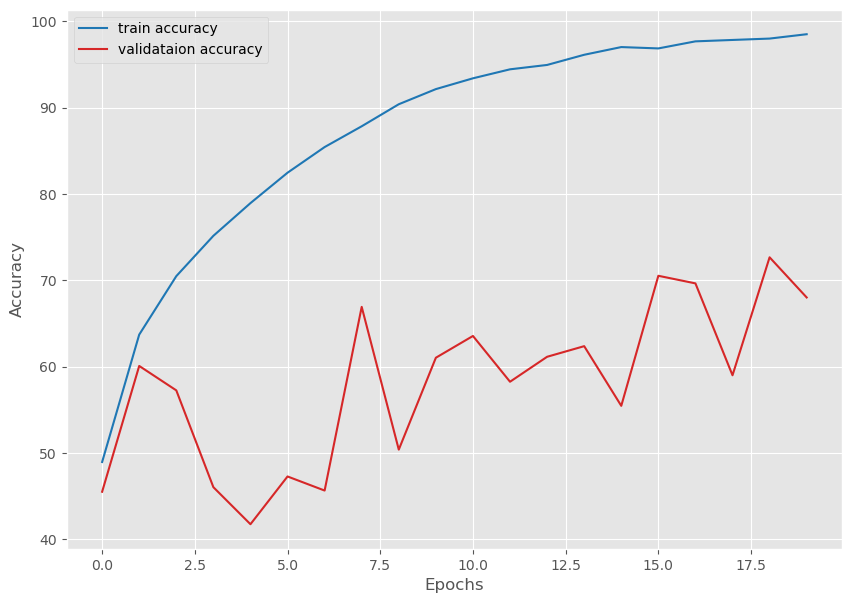

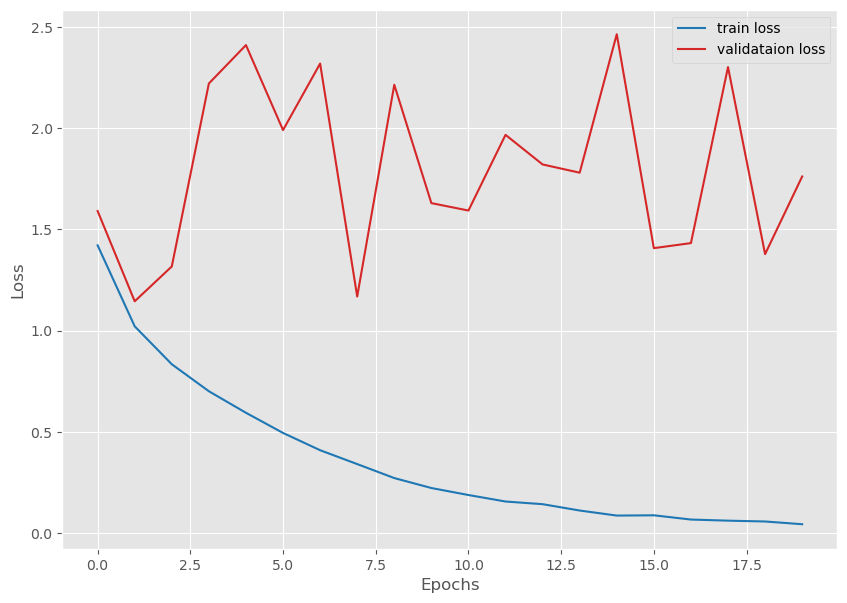

TRAINING COMPLETE


In [ ]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_loader, 
        criterion,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
# Save the loss and accuracy plots.
save_plots(
    train_acc, 
    valid_acc, 
    train_loss, 
    valid_loss, 
    name=plot_name
)
print('TRAINING COMPLETE')